In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 3.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=e2d4a3cf629bdc4c573c0103fb1beeb3b09ac9a4889825517df83bbe2ad54f24
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
cp: cannot stat 'kaggle.json': No such file or directory
ls: cannot access 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  F

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!ls -lha kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c aiseaweather
!unzip aiseaweather.zip

-rw-r--r-- 1 root root 64 Jun 29 13:06 kaggle.json
  0% 0.00/37.2k [00:00<?, ?B/s]
100% 37.2k/37.2k [00:00<00:00, 29.0MB/s]
Archive:  aiseaweather.zip
  inflating: submit_sample.csv       
  inflating: test_wave.csv           
  inflating: train_wave.csv          


In [6]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화
import torchvision.datasets as data
import torchvision.transforms as transforms
import random
from torch.utils.data import  TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [57]:
device = torch.device('cuda') # 디바이스 GPU 설정
torch.manual_seed(777)
random.seed(777)
torch.cuda.manual_seed_all(777)

learning_rate = 0.01
training_epochs = 5000
batch_size = 100

In [58]:
xy_train = pd.read_csv('train_wave.csv', header = None, skiprows=1, usecols=range(2, 13))
x_data = xy_train.loc[:1705, 1:11]
y_data = xy_train.loc[:1705, [12]]
x_data = np.array(x_data)
y_data = np.array(y_data)

scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)

x_train = torch.FloatTensor(x_data).to(device)
y_train = torch.FloatTensor(y_data).to(device) 

In [59]:
train_dataset = TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           drop_last = True)

In [68]:
linear1 = torch.nn.Linear(10, 32,bias=True)
linear2 = torch.nn.Linear(32, 32,bias=True)
#linear4 = torch.nn.Linear(5, 5,bias=True)
linear3 = torch.nn.Linear(32, 1,bias=True)
relu = torch.nn.ReLU()

torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)

model = torch.nn.Sequential(linear1,relu,
                            linear2,relu,
#                            linear4,relu,
                            linear3).to(device)

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

losses = []
model_history = []
err_history = []

total_batch = len(data_loader)
model.train()

for epoch in range(training_epochs + 1):
  avg_cost = 0

  for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = torch.mean((hypothesis - Y) ** 2)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  model_history.append(model)
  err_history.append(avg_cost)
  
  if epoch % 10 == 0:  
    print('Epoch:', '%d' % (epoch + 1), 'Cost =', '{:.9f}'.format(avg_cost))
  losses.append(cost.item())
print('Learning finished')

Epoch: 1 Cost = 1.876972198
Epoch: 11 Cost = 0.059649598
Epoch: 21 Cost = 0.048686534
Epoch: 31 Cost = 0.042635117
Epoch: 41 Cost = 0.040480208
Epoch: 51 Cost = 0.042039081
Epoch: 61 Cost = 0.041758504
Epoch: 71 Cost = 0.037302677
Epoch: 81 Cost = 0.037247550
Epoch: 91 Cost = 0.039555542
Epoch: 101 Cost = 0.040316153
Epoch: 111 Cost = 0.036438249
Epoch: 121 Cost = 0.039395627
Epoch: 131 Cost = 0.035512824
Epoch: 141 Cost = 0.051458862
Epoch: 151 Cost = 0.036349431
Epoch: 161 Cost = 0.035517707
Epoch: 171 Cost = 0.033965863
Epoch: 181 Cost = 0.034455728
Epoch: 191 Cost = 0.042675525
Epoch: 201 Cost = 0.034743518
Epoch: 211 Cost = 0.037273519
Epoch: 221 Cost = 0.035007894
Epoch: 231 Cost = 0.034660131
Epoch: 241 Cost = 0.034622900
Epoch: 251 Cost = 0.031694323
Epoch: 261 Cost = 0.036426548
Epoch: 271 Cost = 0.035285193
Epoch: 281 Cost = 0.032745320
Epoch: 291 Cost = 0.031386726
Epoch: 301 Cost = 0.033880118
Epoch: 311 Cost = 0.033572640
Epoch: 321 Cost = 0.030221419
Epoch: 331 Cost = 0.0

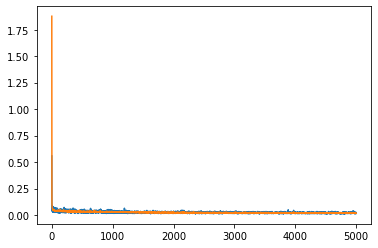

In [70]:
plt.plot(losses)
plt.plot(err_history)
plt.show()

In [71]:
best_model = model_history[np.argmin(err_history)]

In [72]:
xy_test = pd.read_csv('test_wave.csv', header = None, skiprows=1, usecols = range(2, 12))
x_data = xy_test.loc[:, 1:11]
x_data = np.array(x_data)
x_data = scaler.transform(x_data)
x_test = torch.FloatTensor(x_data).to(device)

with torch.no_grad():
    model.eval()  # 주의사항 (dropout=False)
    
    predict = best_model(x_test)

In [73]:
predict

tensor([[2.9116],
        [2.8879],
        [3.0788],
        [2.5700],
        [1.6982],
        [3.0498],
        [2.9676],
        [2.4488],
        [2.2106],
        [2.4123],
        [4.1241],
        [4.7974],
        [2.9727],
        [3.2076],
        [1.9855],
        [3.8418],
        [2.3799],
        [1.6646],
        [2.3287],
        [3.2260],
        [2.1797],
        [1.3617],
        [3.0669],
        [2.9647],
        [3.2842],
        [2.4659],
        [2.5797],
        [1.6802],
        [2.5527],
        [2.1951],
        [1.6102],
        [2.0482],
        [1.8317],
        [0.9281],
        [2.4643],
        [1.1896],
        [2.0212],
        [1.7302],
        [1.6645],
        [1.2516],
        [1.5702],
        [0.8740],
        [0.6420],
        [0.6073],
        [0.7628],
        [1.3334],
        [1.1853],
        [1.0359],
        [3.1772],
        [2.1166],
        [2.4301],
        [1.6704],
        [2.0927],
        [2.2340],
        [3.8058],
        [2

In [74]:
submit = pd.read_csv('submit_sample.csv')
submit['Expected'] = submit['Expected'].astype(float)
for i in range(len(predict)):
  submit['Expected'][i] = predict[i]
submit.to_csv('submit.csv', index = False, header = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [75]:
!kaggle competitions submit -c aiseaweather -f submit.csv -m "gg"

100% 9.70k/9.70k [00:01<00:00, 6.49kB/s]
Successfully submitted to SejongAI.텀프로젝트.[해양기상부이 바다 날씨 예측]